# Описание проекта: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг
Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных
Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

# Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import phik
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import cv
from catboost import Pool
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler


pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

RANDOM_STATE = 30723
PERIOD = pd.to_datetime('2020-02-01')

In [ ]:
try:
    df_contract = pd.read_csv('/content/contract_new.csv')
    df_internet = pd.read_csv('/content/internet_new.csv')
    df_personal = pd.read_csv('/content/personal_new.csv')
    df_phone = pd.read_csv('/content/phone_new.csv')
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')

In [ ]:
def roc_auc_plot(data_y, data_score):
    print(f'ROC-AUC: {roc_auc_score(data_y, data_score)}', end='\n')
    plt.figure(figsize=(7,5))
    fpr, tpr, thr = roc_curve(data_y, data_score)
    plt.plot(fpr, tpr, color='green', lw=2)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC')
    plt.grid()

In [ ]:
def information(data):
    print(data.head(3), end='\n\n')
    print(f'Размер датафрейма: {len(data)}', end='\n\n')
    print(f'Количество пропусков: \n{data.isna().sum()}')

In [ ]:
information(df_contract)

   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   

      PaymentMethod  MonthlyCharges TotalCharges  
0  Electronic check           29.85        31.04  
1      Mailed check           56.95      2071.84  
2      Mailed check           53.85       226.17  

Размер датафрейма: 7043

Количество пропусков: 
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [ ]:
information(df_internet)

   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  

Размер датафрейма: 5517

Количество пропусков: 
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [ ]:
information(df_personal)

   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No

Размер датафрейма: 7043

Количество пропусков: 
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [ ]:
information(df_phone)

   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No

Размер датафрейма: 6361

Количество пропусков: 
customerID       0
MultipleLines    0
dtype: int64


В файле "phone" и "internet" меньше строк. Видимо есть люди, которые не подключали себе телефонные или интернет услуги.

Смерджим в один df

In [ ]:
df = df_contract.merge(df_personal, how='left', on='customerID')
df = df.merge(df_phone, how='left', on='customerID')
df = df.merge(df_internet, how='left', on='customerID')

In [ ]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [ ]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

Заменим пропуски на 'No', поскольку это пользователи, которые не подключили услуги интернета / телефонии

In [ ]:
df = df.fillna('No')

Столбец 'EndDate' содержит данные о расторжении договора, преобразуем данные для бинарной классификации.

Выделим целевую переменную

In [ ]:
df['Churn'] = df['EndDate'].apply(lambda x: 0 if x=='No' else 1)

In [ ]:
df['Churn'].value_counts()

0    5942
1    1101
Name: Churn, dtype: int64

Переведем дату подписания договора во временной формат

In [ ]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')

In [ ]:
df['EndDate'] = df['EndDate'].replace('No', PERIOD)
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

# Подготовка данных

In [ ]:
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,0


Посмотрим на распределние дат заключения договоров

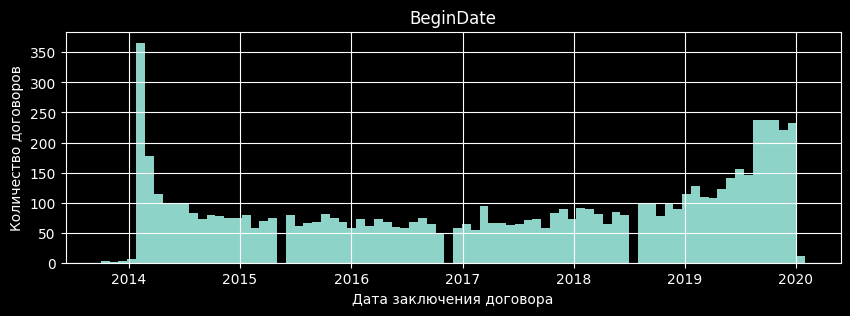

In [ ]:
plt.figure(figsize=(10,3))
df['BeginDate'].hist(bins=80)
plt.xlabel('Дата заключения договора')
plt.ylabel('Количество договоров')
plt.title('BeginDate')
None

Заключено много договоров вначале периода, возможно компания как раз появилась на рынке в этот момент. В некоторые месяца не заключались договора, а так же наблюдается рост количества заключенных договоров ближе к концу периода - много новых клинтов.

Посмотрим на распределение продолжительности договоров

In [ ]:
df['period'] = round((df['EndDate'] - df['BeginDate']) / np.timedelta64(1, 'D'), 0)

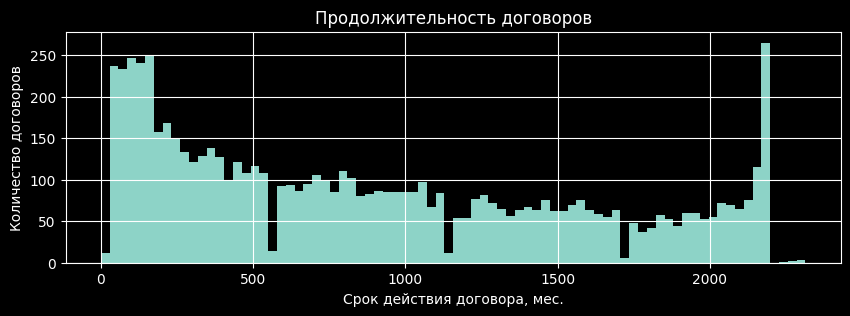

In [ ]:
plt.figure(figsize=(10,3))
df['period'].hist(bins=80)
plt.xlabel('Срок действия договора, мес.')
plt.ylabel('Количество договоров')
plt.title('Продолжительность договоров')
None

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  MultipleLines     7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

Переведем столбы в корректный формат

In [ ]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Удалим не нужные столбцы

In [ ]:
df = df.drop(['customerID', 'EndDate', 'BeginDate'], axis=1)

Посмотрим на все категориальные фичи

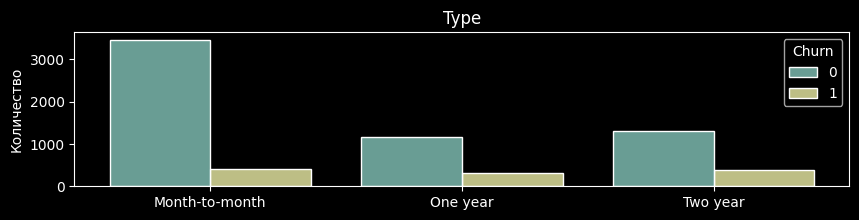

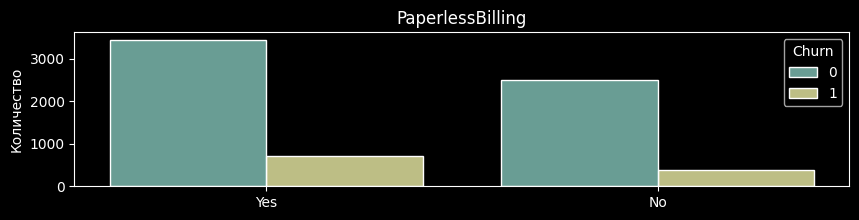

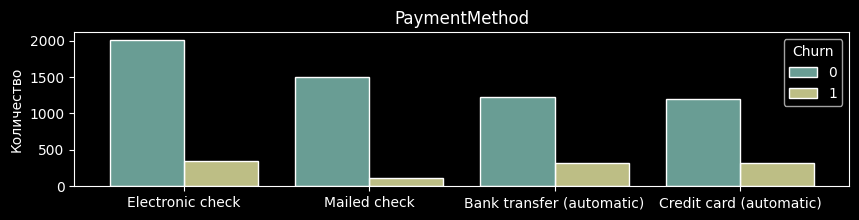

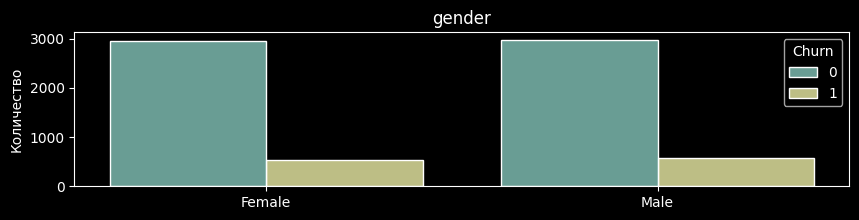

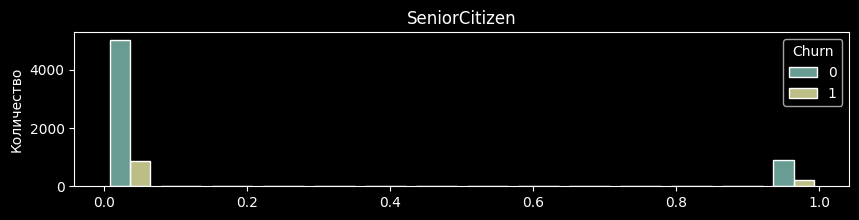

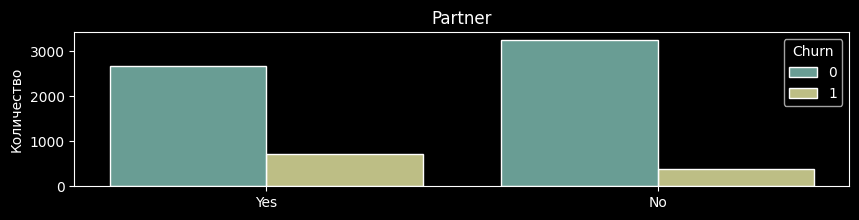

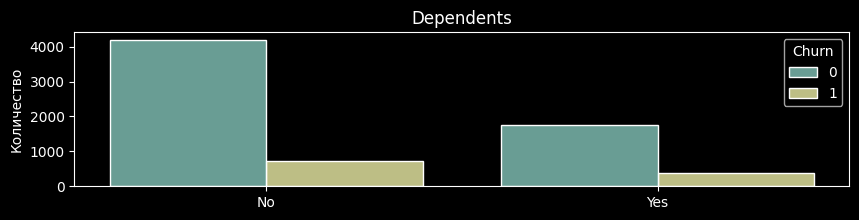

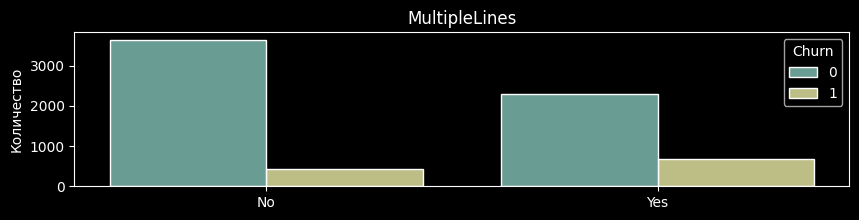

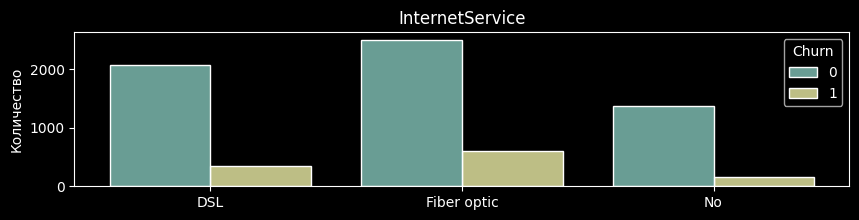

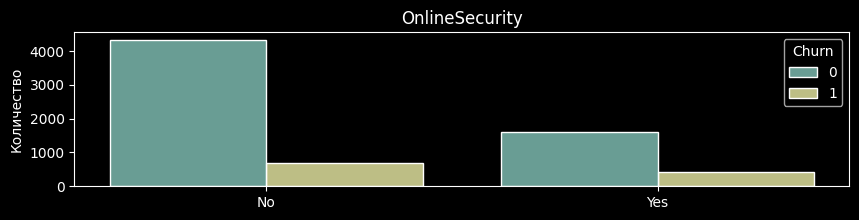

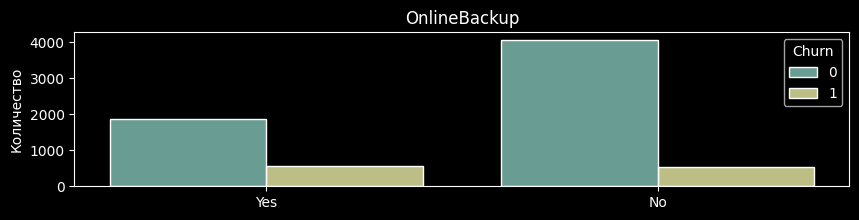

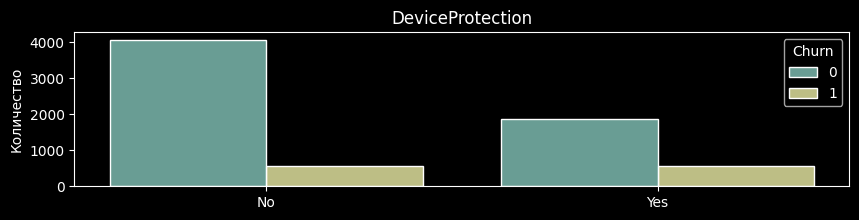

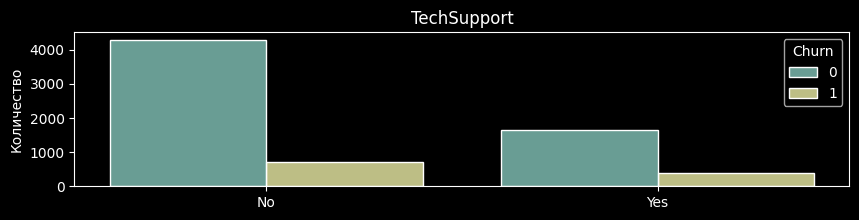

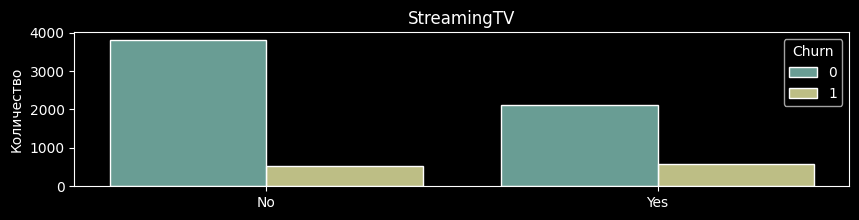

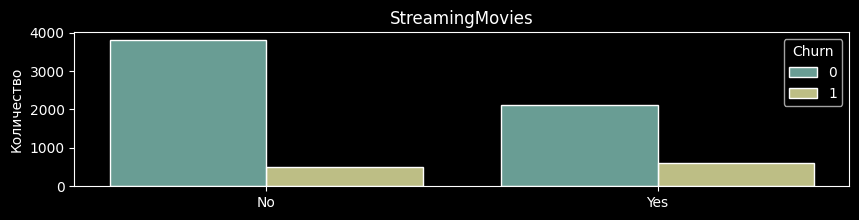

In [ ]:
object_columns = df.select_dtypes(include=['object']).columns

for column in object_columns:
    plt.figure(figsize=(10,2))
    sns.histplot(data=df, x=column, hue='Churn', multiple='dodge', shrink=.8)
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('Количество')


Наблюдения:
1. Основной метод оплаты - Month-to-month используют примерно 50% пользователей, два других One yea и Two year используют примерно по 25% пользователей.
2. Использование безбумажной оплаты более популярно.
3. Electronic check больше всего, Mailed check, Credit card, Bank transfer примерно одинаково.
4. Количество женщин и мужчин приблизительно одинаково.
5. Одинокие клиенты чаще уходят из компании.
6. Вероятность ухода клиента меньше, если оплата помесечная.
7. Остальные признаки не оказывают существенного влияния на таргет. Доля ушедших приблизительно пропорциональна количеству пользователей данной категории.


Посмотрим на корреляцию числовых признаков

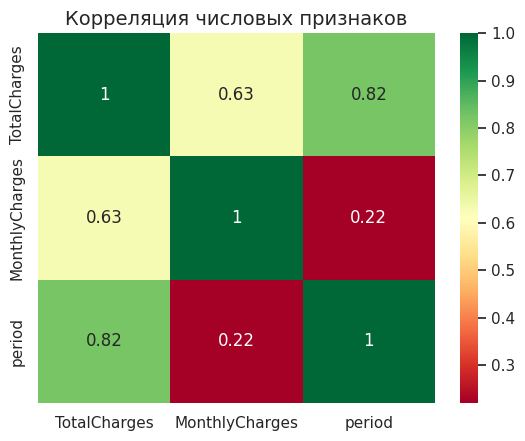

In [ ]:
numeric = df[['TotalCharges', 'MonthlyCharges', 'period']]
sns.set(font_scale=1)
sns.heatmap(numeric.corr(), cmap='RdYlGn', annot=True)
plt.title('Корреляция числовых признаков', fontsize=14)
None

Большая корреляция между общей суммой платежей и период пользования, что в целом выглядит логично. Между ежемесячным платежом и общей суммой тоже есть корреляция, чем больше ежемесячный платеж, тем больше итоговая сумма - предсказуемо

In [ ]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Churn', 'period']


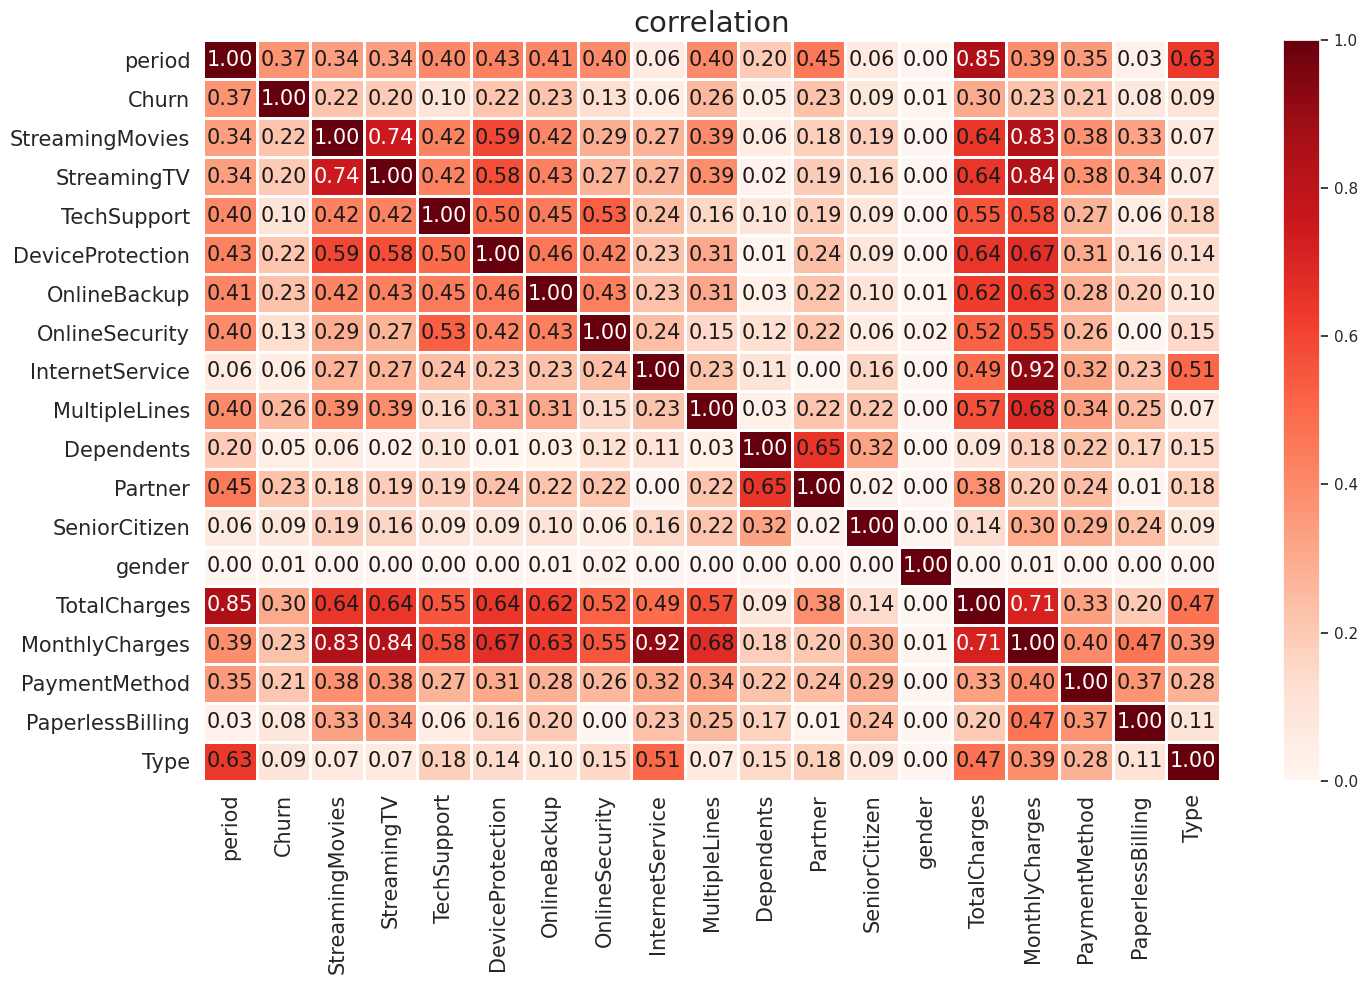

In [ ]:
plot_correlation_matrix(phik_overview.values,
                       x_labels = phik_overview.columns,
                       y_labels = phik_overview.index,
                       vmin = 0,
                       vmax = 1,
                       color_map = 'Reds',
                       fontsize_factor = 1.5,
                       figsize = (15, 10)
                       )

TotalCharges сильно коррелирует с периодом и ежемесечным платежем, удалим этот признак. Распределение по гендеру одинаково - удалим.

In [ ]:
df = df.drop(['TotalCharges', 'gender', 'InternetService'], axis=1)

In [ ]:
df.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn,period
0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,No,No,Yes,No,No,No,No,0,31.0
1,One year,No,Mailed check,56.95,0,No,No,No,Yes,No,Yes,No,No,No,0,1036.0
2,Month-to-month,Yes,Mailed check,53.85,0,No,No,No,Yes,Yes,No,No,No,No,0,123.0
3,One year,No,Bank transfer (automatic),42.30,0,No,No,No,Yes,No,Yes,Yes,No,No,0,1371.0
4,Month-to-month,Yes,Electronic check,70.70,0,No,No,No,No,No,No,No,No,No,0,153.0


# LogisticRegression

Закодируем признаки

In [ ]:
df.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn,period
0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,No,No,Yes,No,No,No,No,0,31.0
1,One year,No,Mailed check,56.95,0,No,No,No,Yes,No,Yes,No,No,No,0,1036.0
2,Month-to-month,Yes,Mailed check,53.85,0,No,No,No,Yes,Yes,No,No,No,No,0,123.0


In [ ]:
df = df.dropna()

In [ ]:
features = df.drop(columns=['Churn'])
target = df['Churn']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=df['Churn'])

In [ ]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [ ]:
features_train.columns == features_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Масштабируем признаки

In [ ]:
numeric = ['MonthlyCharges', 'period']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [ ]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [ ]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)

In [ ]:
search_lr = GridSearchCV(model_lr, param_grid_lr, cv=3, scoring='roc_auc')

In [ ]:
search_lr.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=30723),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

In [ ]:
search_lr.best_params_

{'C': 1}

In [ ]:
predict = search_lr.best_estimator_.predict_proba(features_test)[0:, 1]

ROC-AUC: 0.755646641380154


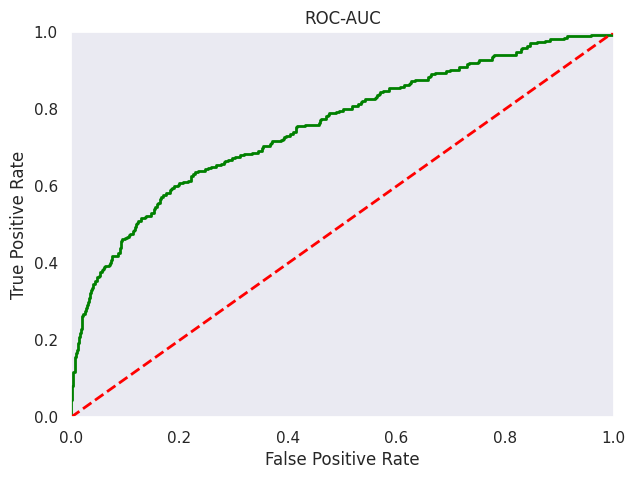

In [ ]:
roc_auc_plot(target_test, predict)

Значение ROC-AUC на train 0.755

# Catboost

In [ ]:
features = df.drop(columns=['Churn'], axis=1)
target = df['Churn']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=df['Churn'])

In [ ]:
X = ['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
     'SeniorCitizen', 'Partner', 'MultipleLines',
     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
     'StreamingMovies', 'period'
     ]

y = ['Churn']

cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod',
                'SeniorCitizen', 'Partner', 'MultipleLines',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                 'StreamingMovies'
                 ]

In [ ]:
params_cb = {'cat_features': cat_features,
             'verbose': 0,
             'auto_class_weights':'Balanced',
             'random_seed': RANDOM_STATE
             }

In [ ]:
grid_cb = {'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
           'depth': range(2, 15, 3),
           'iterations': [100, 200, 300, 400, 500]
          }

In [ ]:
model = CatBoostClassifier(**params_cb)

In [ ]:
search_cb = RandomizedSearchCV(model, grid_cb, cv=5, scoring='roc_auc', n_iter=5)

In [ ]:
search_cb.fit(features_train[X], target_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f4328cc9c60>,
                   n_iter=5,
                   param_distributions={'depth': range(2, 15, 3),
                                        'iterations': [100, 200, 300, 400, 500],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4]},
                   scoring='roc_auc')

In [ ]:
search_cb.best_score_

0.8849979536129873

In [ ]:
search_cb.best_params_

{'learning_rate': 0.3, 'iterations': 400, 'depth': 8}

Catboost на train показал ROC-AUC = 0.88

# Проверка CatBoost на test

In [ ]:
predict = search_cb.best_estimator_.predict_proba(features_test[X])[0:, 1]

ROC-AUC: 0.8880704759574208


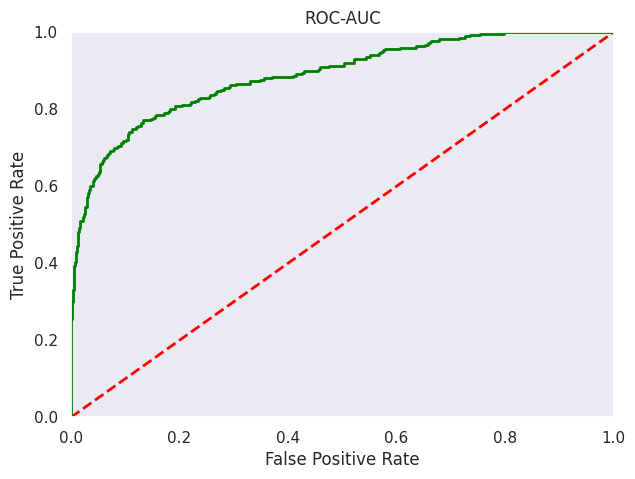

In [ ]:
roc_auc_plot(target_test, predict)

# Анализ features importance для CatBoost

In [ ]:
feature_importances = pd.DataFrame(search_cb.best_estimator_.feature_importances_,
             index=features[X].columns,
             columns=['Importances']).sort_values(by='Importances', ascending=False)

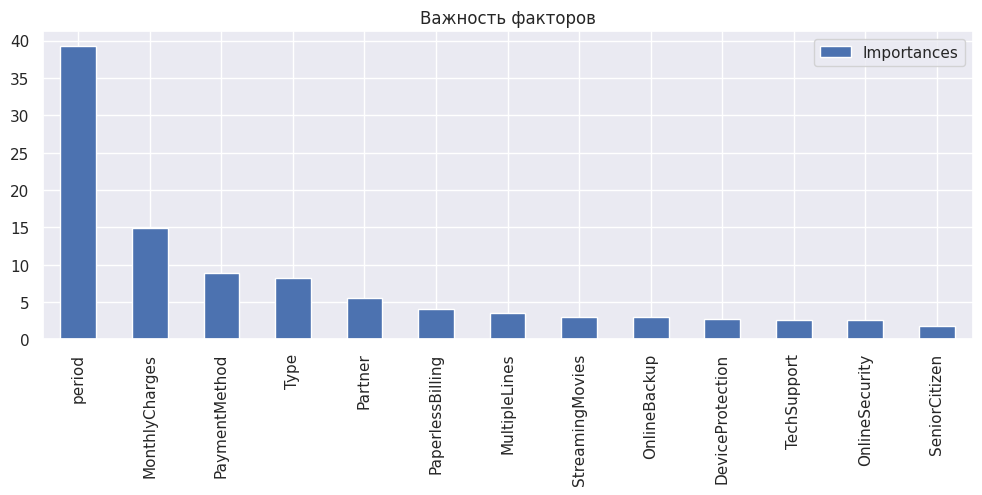

In [ ]:
feature_importances.plot(kind='bar', figsize=(12,4), title='Важность факторов');

Самой важной фичей является период действия договора, а так же тип оплаты. Остальные признаки практически не оказывают влияния на таргет, что и было отмечено в EDA.

# Вывод:

- В рамках данной работы проведен анализ и построена модель предсказания оттока клиентов;
- Произведена первичная предобработка данных, добавлены 2 новых столбца и удалены лишние;
- Произведен EDA и сделаны первые выводы;
- Построены 2 модели: LogisticRegression и CatBoost
- Лучший результат показала модель CatBoost с результатом на тестовой выборке ROC-AUC = 0.97;
- Самые важные факторы: период действия договора, тип оплаты(помесячный / раз в год / раз в два года).

# Отчет:

В рамках данного проекта было выполнено:
1. На первом этапе был собран датасет из 4 исходных таблиц, соединенный по `customerID `. После сборки образовались пропуски, так как в 2-х датасетах отсутствовали часть клинтов. Пропуски в признаках были заполнены "No", так как это означает, что клиенты не пользуются данной услугой.
2. Предобрабодка данных, были помененены типы данных у признаков `BeginDate`, `EndDate` - на `datetime`, а у `MonthlyCharges` и `TotalCharges` на `float`. Добавлен признак `period`, показывающий продолжительность времени использовния услуг на момент выгрузки данных. Выделен целевой признак `Churn` означающий факт ухода клиента (1- клиент ушел, 0 - остался).
3. Перед обучением были удалены признаки `BeginDate` и `EndDate`, так как вместо них был добавлен признак `period`. Удален `gender` по причине отсутствия влияния на целевой признак и удаален `TotalCharges`, так как имеет сильную корреляция с таргетом `Churn`.
4. После более детального рассмотрения, удалось сделать следующие выводы:
- основной метод оплаты - Month-to-month используют примерно 50% пользователей, два других One yea и Two year используют примерно по 25% пользователей;
- использование безбумажной оплаты более популярно;
- Electronic check больше всего, Mailed check, Credit card, Bank transfer примерно одинаково;
- количество женщин и мужчин приблизительно одинаково;
- одинокие клиенты чаще уходят из компании;
- вероятность ухода клиента меньше, если оплата помесечная;
5. Дальнейшем этапом работы стала подготовка данных для обучения моделей и обучение на кроссвалидации. В рамках проекта было рассмотрено 2 модели: LogisticRegression и CatBoostClassifier. Для логистической регрессии была произведена предобработка - кодирование категориальных признаков и масштабирование числовых. Обучение производилось на всех фичах, за исключением `BeginDate`, `EndDate`, `TotalCharges`, `gender`. И добавлены новые: `period` и целевой `Churn`. С помощью CatBoost этапы кодирование и масштабирования удалось избежать, используя встроенный параметр для работы с категориальными признаками, которых у нас большинство.
6. Итоговая модель CatBoost, показавшая луйший результат на тренировочной выборки, имеет гиперпараметры `learning_rate`: 0.3, `iterations`: 400, `depth`: 8 со значение `ROC-AUC` = 0.89. Размер тестовой выборки 0,25, значение `random_state`=30723.
7. Проект выполнен согласно плану, но в ходе его выполнения возникли трудности по достижению целевого значения 0,85 для метрики ROC-AUC. Для этого пришлось подбирать гиперпараметры и удалять/добавлять признаки.
8. Важными этапами при выполнения работы считаю были:
- правильное соединение данных в один датафрейм;
- выделение целевого признака и дополнительных признаков;
- обработка пропусков;
- предобработка данных перед обучения;
- подбор гиперпараметров.